In [1]:
# warning nltk demande des data 

#nltk.download ()
#nltk.download('averaged_perceptron_tagger') # indispensable pour word_tokenize ?

In [9]:
 = import gensim
print (gensim.models.word2vec.FAST_VERSION)

1


In [10]:
gensim.__version__

'3.8.3'

In [11]:
import numpy as np
np.__config__.show()

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]


In [12]:
import numpy.distutils.system_info as sysinfo
sysinfo.get_info('atlas')

{'language': 'f77',
 'libraries': ['lapack', 'f77blas', 'cblas', 'atlas', 'f77blas', 'cblas'],
 'library_dirs': ['/usr/lib/x86_64-linux-gnu'],
 'define_macros': [('NO_ATLAS_INFO', -1)]}

In [15]:


#%save Embedding.py 10


In [10]:
#Import all the dependencies

from gensim.models.doc2vec import Doc2Vec, TaggedDocument, TaggedLineDocument
from gensim.test.utils import get_tmpfile
from nltk.tokenize import word_tokenize
import nltk
import pandas as pd
import numpy as np
import os, json ,sys, time
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
import multiprocessing


path = "../outils"
if path not in sys.path : 
    sys.path.append (path)
from validationPath import validationPath    
from Kernel_BE import Kernel





class Embedding () :
    def __init__ (self,arg) :
        

        
        self.dico_systeme = arg ['pathDico_systeme']
        
        # lecture des parametres de l embedding (dans dico _embedding)
        self.vector_size = self.dico_systeme ['embedding'] ['vector_size']
        self.alpha = self.dico_systeme ['embedding'] ['alpha']
        self.min_alpha = self.dico_systeme ['embedding']['min_alpha']   #0.00025,
        self.min_count = self.dico_systeme ['embedding']['min_count']          # 1, # on peut retirer les mots qui se repete peu
        self.dm = self.dico_systeme ['embedding']['dm']                #1 no BoW 
        self.max_epoch = self.dico_systeme['embedding'] ['max_epoch']   # nombre d iteration pour apprentissage du RN                              
        self.decrease_alpha = self.dico_systeme ['embedding'] ['decrease_alpha'] # decroissance du pas de retro propagation
        self.isOublie = self.dico_systeme ['embedding'] ['isOublie']
        
        self.cores = multiprocessing.cpu_count()
        
        self.pathFile_model = arg ['pathModele']
        
        validationPath (self.pathFile_model)
        # lecture du model si necessaire (premier apprentissage)
        if not os.path.exists(self.pathFile_model) :
            self.init_model ()
        else :
            
            abs_path = os.path.abspath(self.pathFile_model)
            self.model = Doc2Vec.load(abs_path)
            
        return
    
           
    def init_model (self,) :
        
        
        
        self.model = Doc2Vec(vector_size= self.vector_size,
                                alpha=self.alpha, 
                                min_alpha= self.min_alpha, #0.00025,
                                min_count= self.min_count,     # on peur retirer les mots qui se repete peu
                                dm =self.dm,
                                 workers = self.cores,
                            
                            ) # 1 no BoW
        
        
        self.debug_model()
        return
    
    
    
    def apprentissage (self, data,
                       isDocument = True,
                       total_examples = 24,
                       total_words =  3792,
                      ) :
        
        # apprend par bloc recu et on sauve le modele (pour inference si la phase de train est fini )
        # le format d entree data = { ID_pas : ['mots,' ] 
        # ou ID_pas est l ID qui permet de recuperer le vecteur embedding (à recalculer ?)
        # le calcul est en non supervise
        
        
        if isDocument :
            
            tagged_data = [TaggedDocument(words = _d  ,
                                          tags=[str(ID_pas)]) for ID_pas, _d in data.items()]






            liste_mot  = self.get_vocabulaire()
            if len(liste_mot) == 0 :
                self.model.build_vocab(tagged_data,) # à voir si on perd des mots ? 
            else:
                pass


            
            self.model.train(corpus_iterable = tagged_data, 
                                    total_examples = self.model.corpus_count,
                                    epochs = self.max_epoch,
                                 
                                )

                
            

            return
        
        else:
            
            self.model.train(corpus_file = data,
                             epochs = self.max_epoch,
                            total_examples = total_examples,
                            total_words =  total_words,
                           )

            return
             
    
    def save_model (self,) :
        # on sauve un modele qui peut continuer à apprendre 
        fname = os.path.abspath(self.pathFile_model)
        self.model.save(fname)
        self.model = Doc2Vec.load(fname)
        return

    
    def infer_vecteur_embedding (self, data) :
        # data = vecteur de mots (en lower # pas une phrase
        return self.model.infer_vector(data)
        
    def get_vocabulaire (self,) :
        
        r =[mot for mot in self.model.wv.key_to_index.keys()]
        return r
    
    def debug_model (self, ) :
        # bug Gensim
        # on fait un premier apprentissage  pour eviter la bug ()
        # 
        
        dico = {'_init' : ['patrick', 'laffitte']}
        
        self.apprentissage (dico)
        return
        
        dico = {'_init' : ['patrick', 'laffitte']}
        
        tagged_data = [TaggedDocument(words = _d  ,
                                          tags=[str(ID_pas)]) for ID_pas, _d in dico.items()]
        
        self.model.build_vocab(tagged_data,) # à voir si on perd des mots ? 
        return
    

        
    
    

class Gestion_vecteur(Embedding) :
    
    'permet de réaliser les fonctions necessaires sur les vecteurs'
    'comme la normalisation'
    'Warning calcul par inference paragraphe => vecteur'
    
    def __init__ (self, arg) :
        
        super().__init__ (arg)
        
        
    def get_vecteur_array (self,dico_paragraphes) :
        
        resultat = []
        liste_ID = [ID for ID in dico_paragraphes.keys()]
        for ID in liste_ID :
            data = dico_paragraphes [ID]
            vecteur = self.infer_vecteur_embedding (data)
            resultat.append (vecteur)
            continue
        return np.array (resultat), liste_ID
    
    def get_vecteur_normalized (self, dico_paragraphe) :
        tableau, liste_ID = self.get_vecteur_array (dico_paragraphe) 
        normalized_array = sklearn.preprocessing.normalize(tableau, norm="l2")
        return normalized_array, liste_ID
    
    
        
    def similarite_par_vecteur (self, vecteur_1, vecteur_2 ):
        similarities = cosine_similarity([vecteur_1], [vecteur_2] , )
        return similarities [0] [0]
    
    def calcul_distance (self, vecteur_embedding_0 ,vecteur_embedding_1) :
        # on normalize avant le calcul de distance
        v0 = np.array (vecteur_embedding_0)
        v0_0 = v0/np.linalg.norm(v0)
        
        v1 = np.array (vecteur_embedding_1)
        v1_1 = v1/np.linalg.norm(v1)

        dist =  np.linalg.norm (v0_0 - v1_1)
        return dist  
    

        
        
class Embedding_vecteur (Embedding)  :
    def __init__ (self, index_bulk, dico_out, arg) :
        '''tagged_data
        on delegue à Embedding tous le boulot
        y compris et surtout le loading du modele (parametre dans arg)
        
        initialisation du kernel (pour bulk_vecteur)
        
        dans _iterateur 
        boucle sur IDs du dico_out :
            pour chaque ID , recuperer le vecteur et bulk du vecteur et du paragraphe associé
            
        
            
        
        '''
        
        super().__init__( arg)
        
        kernel_data = self.dico_systeme ['elasticsearch']
        self.kernel = Kernel(kernel_data)
        
        self.index_bulk = index_bulk
        
        
    def _iterateur (self, ) :
        
        for ID, paragraphe in self.dico_out.items():
            
            vecteur = self.infer_vecteur_embedding ( paragraphe)
            doc = {'ID' : ID ,
                  'vecteur' : vecteur,
                   'paragraphe' : paragraphe,
                  }
            yield doc
        
        
    def bulk_vecteur (self, dico_out) :
        
        self.dico_out = dico_out
        
        self.kernel.bulk_vecteur (self._iterateur(),
                                  index = self.index_bulk,
                                  isPurge_existing_index = False,
                                  chunk_size = 2000,
                                 )
        return
    
    
    
    
                           
        
        
        
        
        
        
        

    
    
    
          
        
        

In [1]:
import json, sys, os, time
import numpy as np

from gensim.utils import save_as_line_sentence
from gensim.parsing.preprocessing import preprocess_string

path = "../outils"
if path not in sys.path : 
    sys.path.append (path)
from Entree_sortie_lock import Entree_sortie_lock
    
from Kernel_BE import Kernel

from Embedding import Gestion_vecteur, Embedding




arg = {}

nom_environnement = 'test'
arg ['nom_environnement'] =  nom_environnement


pathFile_evenements = '/dico_evenements_2.json'
pathFile_systeme = '/dico_systeme_2.json'

arg_entree_sortie_lock = {} 
arg_entree_sortie_lock ['nom_environnement'] = nom_environnement
arg_entree_sortie_lock['pathFile'] = pathFile_evenements
Entree_sortie_evenements = Entree_sortie_lock (arg_entree_sortie_lock)
dico_evenements, etat = Entree_sortie_evenements.lire()
arg ['pathDico_evenements'] = dico_evenements

arg_entree_sortie_lock ['pathFile'] = pathFile_systeme
Entree_sortie_systeme = Entree_sortie_lock (arg_entree_sortie_lock)
dico_systeme, etat = Entree_sortie_systeme.lire()
arg ['pathDico_systeme'] = dico_systeme

pas = 'semaine'
pas_date = '2021-02-08 00:00:00.000000'.replace (':', '.').replace (' ', '_')
arg ['pathLuigi_file'] = '../data/test/data/'+ pas + '/' + pas_date + '/'

arg ['pathLuigi_file'] = './'

arg['pathModele'] = '../data/test/data/'+ pas + '/' +'Modele_test4.model'


pathFile = './test_embedding.json'
fin = open (pathFile,'r')
        
dico = {}
for ligne_json in fin:
    dico_ligne = json.loads (ligne_json)
    dico.update(dico_ligne)
    
liste_ID = [ID for ID in dico.keys()]
liste_ID.sort()

arg ['liste_ID'] = liste_ID

E = Gestion_vecteur(arg)
t = time.time()
E.apprentissage (dico)
delaie = time.time() - t
E.save_model ()

print ("apprentissage modele par dico en temps =", delaie)
print ()

pathFile = './test_embedding.json'
fin = open (pathFile,'r')
        
dico = {}
for ligne_json in fin:
    dico_ligne = json.loads (ligne_json)
    dico.update(dico_ligne)
    
liste_ID = [ID for ID in dico.keys()]
liste_ID.sort()


ID_1 = liste_ID [0]
paragraphe_1 = dico [ID_1]
vecteur_calcule_1 = E.infer_vecteur_embedding (paragraphe_1)

ID_2 = liste_ID [len(liste_ID) - 1]
paragraphe_2 = dico [ID_2]
vecteur_calcule_2 = E.infer_vecteur_embedding (paragraphe_2)

similarite1_1 = E.similarite_par_vecteur (vecteur_calcule_1, vecteur_calcule_2)
print ('similarite entre deux paragraphes calculés differents =', similarite1_1 )
distance_1_1 = E.calcul_distance (vecteur_calcule_1 ,vecteur_calcule_2)
print ('distance entre deux paragraphes calculés differents =', distance_1_1)
print ()


print ('conclusion : OK pour l inference sur apprentissage dico ')

#### fin test sur apprentissage dico


arg['pathModele'] = '../data/test/data/'+ pas + '/' +'Modele_test2.model'


corpus = 'mon_corpus.txt'
    

    
def processed_corpus(dico, repetition = 1) :
    
    for _ in range (0, repetition) :
        for ID, ligne in dico.items() :
            doc =  ' '.join (ligne) + '\n'
            # concatenate all section titles and texts of each Wikipedia article into a single "sentence"
            #oc = '\n'.join(itertools.chain.from_iterable(zip(article['section_titles'], article['section_texts'])))
            yield preprocess_string(doc)

# serialize the preprocessed corpus into a single file on disk, using memory-efficient streaming
save_as_line_sentence(processed_corpus(dico), corpus)
        
t = time.time()
E.apprentissage  (corpus, isDocument = False)
delaie = time.time() - t
E.save_model ()

print ("apprentissage modele par fichier =", delaie)
print ()

# serialize the preprocessed corpus into a single file on disk, using memory-efficient streaming
repetition = 200
#save_as_line_sentence(processed_corpus(dico, repetition = repetition), corpus)

def ligne_for_corpus(dico, repetition = 1) :
    
    for _ in range (0, repetition) :
        for ID, ligne in dico.items() :
            doc =  ' '.join (ligne) + '\n'
            # concatenate all section titles and texts of each Wikipedia article into a single "sentence"
            #oc = '\n'.join(itertools.chain.from_iterable(zip(article['section_titles'], article['section_texts'])))
            yield doc

fout = open (corpus, 'w')
for ligne in ligne_for_corpus(dico, repetition = repetition) :
    fout.write (ligne)
fout.close()
    

    
        
t = time.time()
E.apprentissage  (corpus,
                  isDocument = False,
                  total_examples = 24*repetition,
                  total_words = repetition*3792,
                 )
                  
                  
                  
delaie = time.time() - t
E.save_model ()

print ("apprentissage modele par fichier avec repetition ", repetition, ' et un temps =', delaie)
print ()

pathFile = './test_embedding.json'
fin = open (pathFile,'r')
        
dico = {}
for ligne_json in fin:
    dico_ligne = json.loads (ligne_json)
    dico.update(dico_ligne)
    
liste_ID = [ID for ID in dico.keys()]
liste_ID.sort()


ID_1 = liste_ID [0]
paragraphe_1 = dico [ID_1]
vecteur_calcule_1 = E.infer_vecteur_embedding (paragraphe_1)

ID_2 = liste_ID [len(liste_ID) - 1]
paragraphe_2 = dico [ID_2]
vecteur_calcule_2 = E.infer_vecteur_embedding (paragraphe_2)

similarite1_1 = E.similarite_par_vecteur (vecteur_calcule_1, vecteur_calcule_2)
print ('similarite entre deux paragraphes calculés differents =', similarite1_1 )
distance_1_1 = E.calcul_distance (vecteur_calcule_1 ,vecteur_calcule_2)
print ('distance entre deux paragraphes calculés differents =', distance_1_1)
print ()


print ('conclusion : OK pour l inference ')

E = Gestion_vecteur (arg)

normalized_array, liste_ID = E.get_vecteur_normalized (dico)

ID_0 = liste_ID [0]
paragraphe = dico [ID_0]

v0 = E.infer_vecteur_embedding (paragraphe)
v0_0 = v0/np.linalg.norm(v0)

assert (np.sum(normalized_array [0, :] - v0_0) < 10.e-7)

print ('end of job')







apprentissage modele par dico en temps = 0.06233692169189453

similarite entre deux paragraphes calculés differents = 0.4507786
distance entre deux paragraphes calculés differents = 1.0480664

conclusion : OK pour l inference sur apprentissage dico 
apprentissage modele par fichier = 0.0802760124206543

apprentissage modele par fichier avec repetition  200  et un temps = 1.1322667598724365

similarite entre deux paragraphes calculés differents = 0.6129422
distance entre deux paragraphes calculés differents = 0.8798383

conclusion : OK pour l inference 
end of job


In [7]:
corpus = 'mon_corpus.txt'

fin = open (corpus, 'r')

ligne = fin.readline()

ligne

'date even bpm date even lundi date even date even fevrier date even date even non feri laitu bio haut normal espagn laitu bio haut normal prix quartil prix decil prix manuel prix panier quartil date even bpm date even lundi date even date even fevrier date even date even non feri laitu bio haut normal espagn laitu bio haut normal prix quartil prix decil prix manuel prix panier quartil date even bpm date even lundi date even date even fevrier date even date even non feri autr bio haut normal autr bio haut normal prix quartil prix decil prix manuel prix panier quartil date even bpm date even lundi date even date even fevrier date even date even non feri carott bio haut normal espagn carott bio haut normal prix quartil prix decil prix manuel prix panier quartil date even bpm date even jeudi date even date even fevrier date even date even non feri autr bio haut normal autr bio haut normal prix quartil prix decil prix manuel prix panier quartil date even bpm date even jeudi date even date 

In [18]:
"""
ID_0 = couple_enfant_cadre_sup_0
ID_1 = homme_ouvrier_0

similarite meme vecteur memorisé (ID_0) = 1.0000001
distance meme vecteur memorisé (ID_0) = 0.0

similarite meme paragraphe (memorise / inference pour ID_0) = 0.19194607
distance meme paragraphe (memorise / inference pour ID_0) = 1.2ID_0 = couple_enfant_cadre_sup_0
ID_1 = homme_ouvrier_0

similarite meme vecteur memorisé (ID_0) = 1.0000001
distance meme vecteur memorisé (ID_0) = 0.0

similarite meme paragraphe (memorise / inference pour ID_0) = 0.19194607
distance meme paragraphe (memorise / inference pour ID_0) = 1.2712623

similarite 2 paragraphes memorisés differents  = -0.10987528
distance 2 paragraphes memorisés differents  = 1.4898827

similarite entre deux paragraphes calculés differents = 0.6319786
distance entre deux paragraphes calculés differents = 0.8579294
 pd.df (resultat)
conclusion : utiliser le memorisé ou le calculé mais jamais les deux ensemble712623

similarite 2 paragraphes memorisés differents  = -0.10987528
distance 2 paragraphes memorisés differents  = 1.4898827

similarite entre deux paragraphes calculés differents = 0.6319786
distance entre deux paragraphes calculés differents = 0.8579294

conclusion : utiliser le calculé 


"""

a = 1


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
#from sklearn.datasets.samples_generator import make_blobs

%matplotlib inline
#X, y = make_blobs(n_samples=10, centers=4, cluster_std=0.60, random_state=0)

wcss = []
for i in range(1, 24):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(normalized_array)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 24), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('DISPERSION')
plt.show()

NameError: name 'normalized_array' is not defined

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from sklearn import metrics
kmeans = KMeans(n_clusters= 12, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(normalized_array)

labels = []
for ID in liste_ID :
    comportement = '_'.join ( ID.split('_')[:-1])
    labels.append(comportement)

metrics.adjusted_rand_score(kmeans.labels_, labels)

1.0

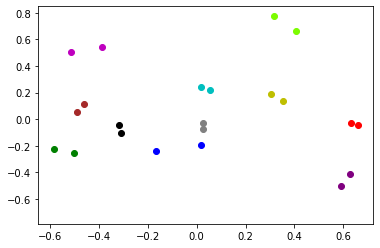

In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
acp = PCA(n_components=2).fit_transform(normalized_array)

BASE_COLORS = {
    'b': (0, 0, 1),        # blue
    'g': (0, 0.5, 0),      # green
    'r': (1, 0, 0),        # red
    'c': (0, 0.75, 0.75),  # cyan
    'm': (0.75, 0, 0.75),  # magenta
    'y': (0.75, 0.75, 0),  # yellow
    'k': (0, 0, 0),        # black
    'w': (0, 1, 1),        # white
}



colors = [couleur for couleur in BASE_COLORS.keys()]
colors.extend(['lawngreen','purple', 'brown' , 'grey', 'brown', 'pink', 'purple'])
colors = colors [0:12]
for couleur,k in zip(colors,range (0, 12)):
    plt.scatter(acp[kmeans.labels_ == k, 0],acp[kmeans.labels_== k,1],c=couleur)
plt.show()

For n_clusters = 10 The average silhouette_score is : 0.42101893
For n_clusters = 11 The average silhouette_score is : 0.39891252
For n_clusters = 12 The average silhouette_score is : 0.40360102
For n_clusters = 13 The average silhouette_score is : 0.3934894
For n_clusters = 14 The average silhouette_score is : 0.38470972


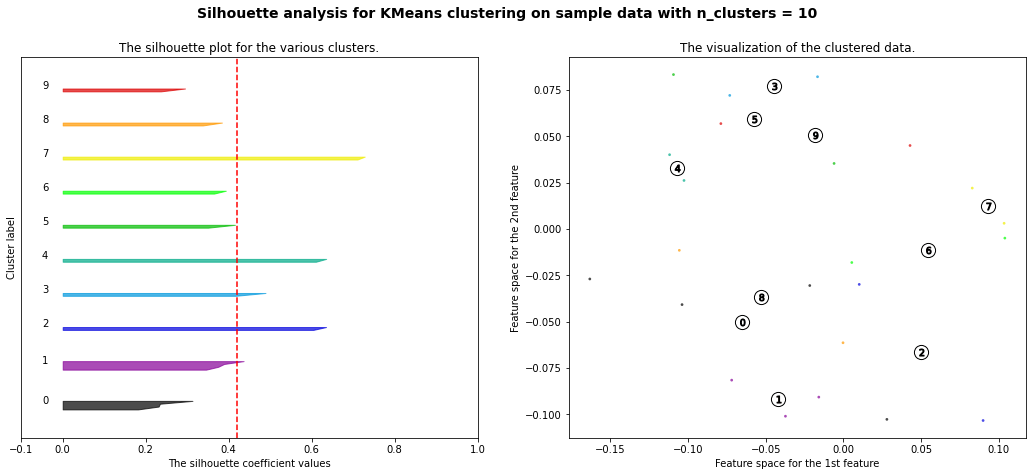

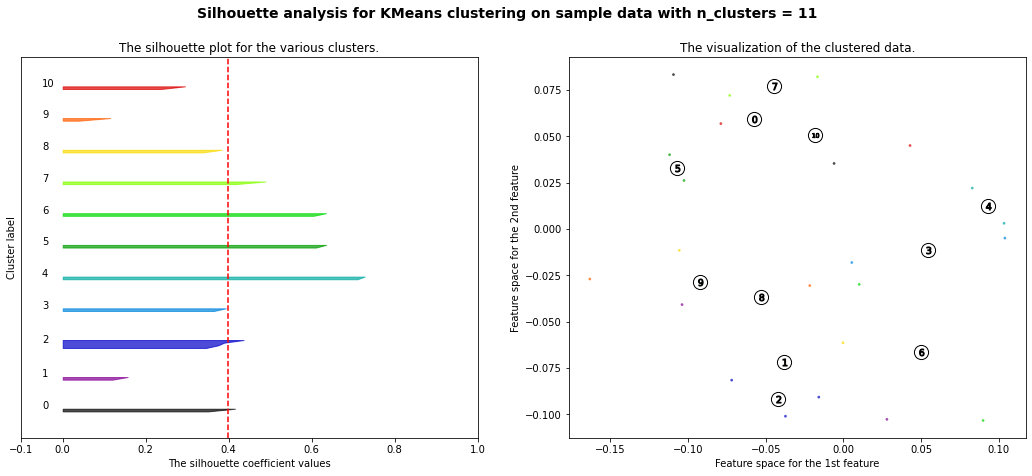

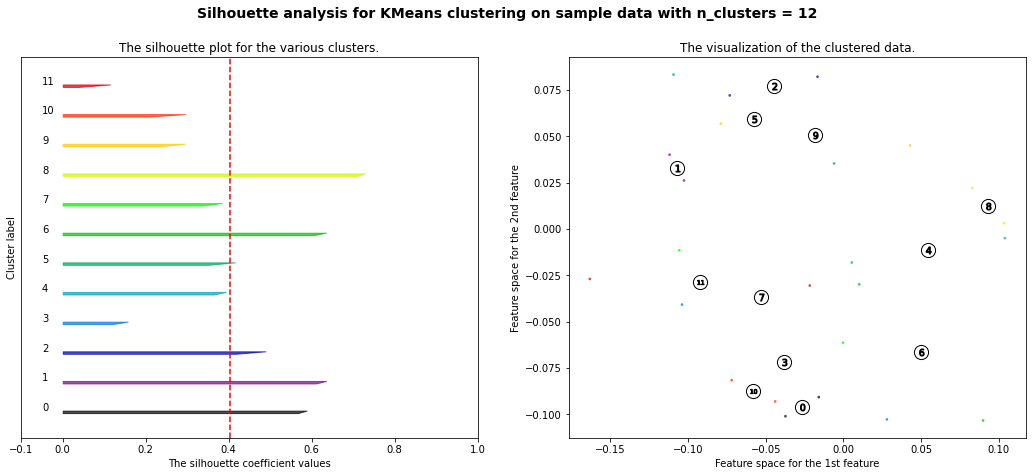

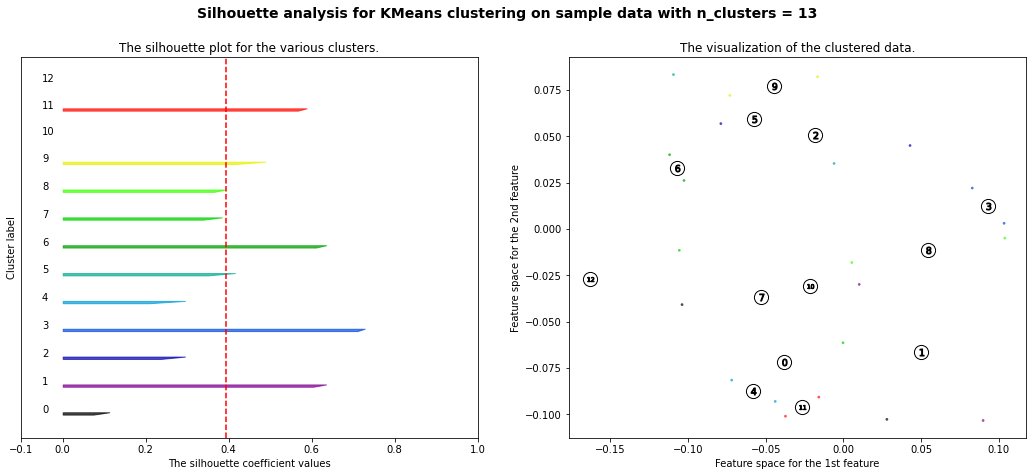

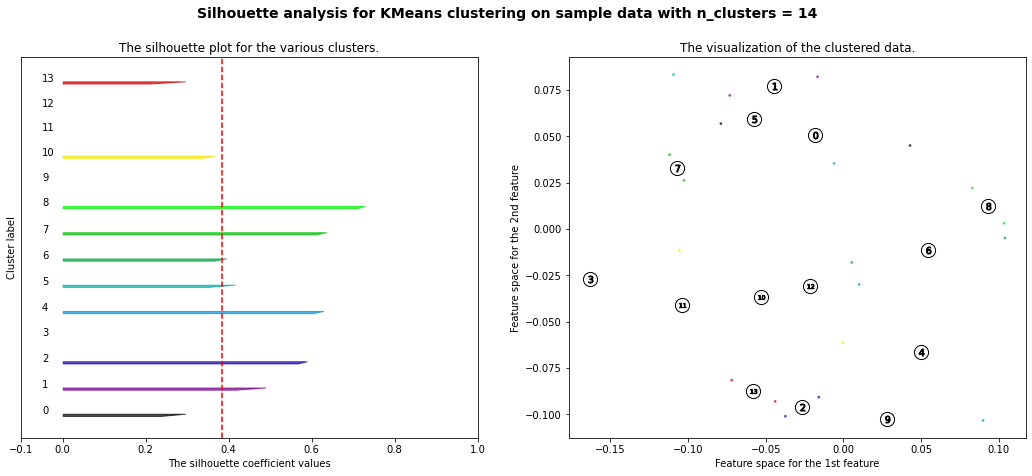

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np



# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.


X = normalized_array
range_n_clusters = [ 10, 11, 12,  13, 14]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()